In [12]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np
import math
from numpy import random
from IPython.display import HTML
import torchvision.models as torch_models
from base64 import b64encode
import os
from IPython.display import Video
from utils import *
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device
print(device)

preprocess = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

yolo_model_path = "weights/detect_large.pt"
model = YOLO(yolo_model_path)
classNames = ['basketball', 'hoop', 'person']

cuda


In [13]:
def inference_by_batch(model, 
                       cls_model,
                       video_path, 
                       cls_conf_threshold = 0.6,
                       detect_conf_threshold = 0.4,
                       save_result_vid = False, 
                       output_dir = None, 
                       saved_video_name = None,
                       batch_size=128,
                       display_result = False,
                       show_progress = True,
                       skip_to_sec = 0,
                       show_score_prob = False,
                       ):
    cap, fps, frame_width, frame_height = get_video_info(video_path)
    if skip_to_sec > 0:
        cap.set(cv2.CAP_PROP_POS_MSEC, skip_to_sec * 1000)
        
    num_skiped_frames = int(skip_to_sec * fps)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - num_skiped_frames
    
    
    if save_result_vid:
        video_name = video_path.split("/")[-1]
        video_name = video_name.split(".")[0] + ".mp4"
        output_path = "inferenced_" + video_name if output_dir is None else os.path.join(output_dir, "inferenced_" + video_name)
        if saved_video_name is not None:
            compressed_output_path = saved_video_name if output_dir is None else os.path.join(output_dir, saved_video_name)
        else:
            compressed_output_path = "compressed_inferenced_" + video_name if output_dir is None else os.path.join(output_dir, "compressed_inferenced_" + video_name)
        codec = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, codec, fps, (frame_width,frame_height))
    
    num_batches = math.ceil(total_frames / batch_size)

    results = []
    score_timestamps = []
    
    count = 0
    score = 0
    display_prob = [0.0]
    
    if show_progress:
        batch_range = tqdm(range(num_batches))
    else:
        batch_range = range(num_batches)

    for i in batch_range:
        frames = []
        for i in range(batch_size):
            ret, img = cap.read()
            if ret:
                frames.append(img)
            else:
                break

        if frames:
            results = model(frames, 
                            stream=False, 
                            verbose = False, 
                            conf=detect_conf_threshold)
        else:
            continue

        for c, r in enumerate(results):
            img = r.orig_img
            boxes = r.boxes
            cropped_images = []
            count += 1
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # convert to int values
                confidence = box.conf.item()
                predicted_class = model.names[int(box.cls)] 
                if predicted_class == "hoop":
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, f'{predicted_class}: {confidence:.3f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                    
                    if x1 > x2 or y1 > y2:
                        continue
                    else:
                        cropped_img = img[y1:y2, x1:x2]
                        cropped_images.append(cropped_img)
                        
                if predicted_class == "basketball":
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f'{predicted_class}: {confidence:.3f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    
            
            if len(cropped_images) == 0:
                continue
            pred, prob = predict_hoop_box_batch(cropped_images, cls_model,  preprocess, device, threshold=cls_conf_threshold)
            if pred.sum() > 0 and count > 60:
                score += 1
                count = 0
                current_frame = i * batch_size + c
                time_stamp = current_frame / fps
                score_timestamps.append((time_stamp, prob))
                display_prob = prob
        
            cv2.putText(img, f'Score: {score}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
            if show_score_prob:
                cv2.putText(img, f'Prob: {max(display_prob):.3f}', (10, 140), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
            if save_result_vid:
                out.write(img)
        if not ret:
            break
        
    if save_result_vid:
        out.release()
    cap.release()
    
    if save_result_vid:
        subprocess.run(['ffmpeg', '-y', '-hide_banner',  '-loglevel', 'error', '-i', output_path, '-vcodec', 'libx264', compressed_output_path], check=False)
        os.remove(output_path)
        if display_result:
            display(Video(compressed_output_path, embed=True))
        return score_timestamps, compressed_output_path
    else:
        return score_timestamps

In [14]:
def inference_by_frame(model, 
                       cls_model,
                       video_path, 
                       cls_conf_threshold = 0.6,
                       detect_conf_threshold = 0.4,
                       save_result_vid = False, 
                       output_dir = None, 
                       saved_video_name = None,
                       display_result = False,
                       show_progress = True,
                       skip_to_sec = 0,
                       show_score_prob = False,
                       
                       ):
    cap, fps, frame_width, frame_height = get_video_info(video_path)
    if skip_to_sec > 0:
        cap.set(cv2.CAP_PROP_POS_MSEC, skip_to_sec * 1000)
        
    num_skiped_frames = int(skip_to_sec * fps)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - num_skiped_frames
    
    
    if save_result_vid:
        video_name = video_path.split("/")[-1]
        video_name = video_name.split(".")[0] + ".mp4"
        output_path = "inferenced_" + video_name if output_dir is None else os.path.join(output_dir, "inferenced_" + video_name)
        if saved_video_name is not None:
            compressed_output_path = saved_video_name if output_dir is None else os.path.join(output_dir, saved_video_name)
        else:
            compressed_output_path = "compressed_inferenced_" + video_name if output_dir is None else os.path.join(output_dir, "compressed_inferenced_" + video_name)
        codec = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, codec, fps, (frame_width,frame_height))
    pbar = tqdm(total=total_frames, desc="Processing Frames", unit="frame") if show_progress else None

    score_timestamps = []
    count=0
    score = 0
    display_prob = [0.0]
    
    while True:
        ret, img = cap.read()
        frame_start_time = time.time()
        current_time = cap.get(cv2.CAP_PROP_POS_MSEC)
        count += 1
        if ret:
            results = model(img, stream = False, device = device, conf = detect_conf_threshold, verbose = False)
            
            for r in results:
                boxes = r.boxes

                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
                    confidence = box.conf[0]
                    predicted_class = model.names[int(box.cls)]
                    
                    # If "basketball-hoops" is detected, make a prediction with cls_model
                    if predicted_class == "hoop":
                        # Crop the image and convert to PIL Image
                        # try:
                        if x1 > x2 or y1 > y2:
                            continue
                        else:
                            _, prediction, prob = predict_hoop_box(img, cls_model, x1, y1, x2, y2, preprocess, device, cls_conf_threshold)
                            if prediction == 1 and count > 60:
                                score += 1
                                count = 0
                                display_prob = prob
                                score_timestamps.append((current_time, prob))

                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, f'{predicted_class}: {confidence:.3f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                    
                    if predicted_class == "basketball":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, f'{predicted_class}: {confidence:.3f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            cv2.putText(img, f'Score: {score}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
            if show_score_prob:
                cv2.putText(img, f'Prob: {display_prob[0]:.3f}', (10, 140), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)

            if show_progress:
                frame_end_time = time.time()  # End time for frame processing
                time_per_frame = frame_end_time - frame_start_time
                pbar.set_postfix(time_per_frame=f"{time_per_frame:.3f} sec")
                pbar.update(1)

            
        else:
            break
        
        if save_result_vid:
            out.write(img)
            
    if save_result_vid:
        out.release()
    cap.release()
    
    if save_result_vid:
        subprocess.run(['ffmpeg', '-y', '-hide_banner',  '-loglevel', 'error', '-i', output_path, '-vcodec', 'libx264', compressed_output_path], check=False)
        os.remove(output_path)
        if display_result:
            display(Video(compressed_output_path, embed=True))
        return score_timestamps, compressed_output_path
    else:
        return score_timestamps

In [15]:
def test_model(model, cls_model, all_made, all_miss, conf = 0.5):
    true_labels = np.array([1] * len(os.listdir(all_made)) + [0] * len(os.listdir(all_miss)))
    predictions = np.empty(len(true_labels))
    i = 0
    for cls in [all_made, all_miss]:
        for vid in tqdm(os.listdir(cls)):
            vid = cls + f"/{vid}"
            result = inference_by_batch(model,
                                        cls_model,
                                        video_path = vid,
                                        save_result_vid = False,
                                        display_result = False,
                                        batch_size = 128,
                                        show_progress=False,
                                        cls_conf_threshold=conf)
            
            predictions[i] = len(result) > 0
            i += 1
    conf_mat = confusion_matrix(true_labels, predictions)
    
    return true_labels, predictions, conf_mat

In [16]:
cls_model_path = "cls_chkpoint_resnet50/checkpoint_2023-12-18-23-08_lr_0.0001_batch_128/best_model.pth"
cls_model = load_resnet50(cls_model_path, device)
cls_model.eval()

all_pos_vid = "video_test_dataset/all_made.mp4"
all_neg_vid = "video_test_dataset/all_miss.mp4"

In [17]:
all_models = [
    "cls_chkpoint_resnet50/checkpoint_2023-12-18-23-08_lr_0.0001_batch_128/checkpoint_epoch_20.pth",
    "cls_chkpoint_resnet50/checkpoint_2023-12-18-23-08_lr_0.0001_batch_128/checkpoint_epoch_60.pth",
    "cls_chkpoint_resnet50/checkpoint_2023-12-18-23-08_lr_0.0001_batch_128/best_model.pth",
    "cls_chkpoint_resnet50/checkpoint_2023-12-18-20-39_lr_0.0001_batch_128/checkpoint_epoch_80.pth"
    "cls_chkpoint_resnet50/checkpoint_2023-12-19-00-34_lr_0.0003_batch_128/checkpoint_epoch_50.pth"
    ]

for model_path in all_models:
    cls_model = load_resnet50(cls_model_path, device)
    cls_model.eval()
    pos_results = inference_by_batch(model,
                    cls_model,
                    video_path = all_pos_vid,
                    save_result_vid = False,
                    display_result = False,
                    batch_size = 128 * 2,
                    show_progress=True,
                    cls_conf_threshold=0.3,
                    )
    pos_score = len(pos_results)
    
    neg_results = inference_by_batch(model,
                    cls_model,
                    video_path = all_neg_vid,
                    save_result_vid = False,
                    display_result = False,
                    batch_size = 128 * 2,
                    show_progress=True,
                    cls_conf_threshold=0.4,
                    )
    neg_score = len(neg_results)
    print(f"{model_path}: pos_score: {pos_score}, neg_score: {neg_score}")

 96%|█████████▌| 24/25 [02:23<00:05,  6.00s/it]


cls_chkpoint_resnet50/checkpoint_2023-12-18-23-08_lr_0.0001_batch_128/checkpoint_epoch_20.pth: pos_score: 66, neg_score: 42


 60%|██████    | 15/25 [01:34<01:03,  6.34s/it]

In [7]:
temp = [(2183.5480333333335, [0.5785512924194336]),
 (2184.6825, [0.3833310604095459]),
 (2181.5126666666665, [0.31676939129829407]),
 (2183.8817, [0.32716891169548035]),
 (2186.5176666666666, [0.3377174437046051]),
 (2180.0111666666667, [0.3242378532886505, 0.19896237552165985]),
 (2183.181, [0.42677193880081177]),
 (2185.4165666666668, [0.3532150685787201]),
 (2182.1132666666667, [0.13085204362869263, 0.32459473609924316]),
 (2184.4823, [0.43319791555404663, 0.12713348865509033]),
 (2179.7442333333333, [0.6700811982154846, 0.10359571874141693]),
 (2181.7796, [0.5128147602081299, 0.15739373862743378]),
 (2183.814966666667, [0.4688536822795868, 0.13595260679721832]),
 (2185.8503333333333, [0.5162473917007446, 0.07325936108827591]),
 (2179.3438333333334, [0.6422990560531616, 0.07534850388765335]),
 (2181.3792, [0.5818678736686707, 0.20527800917625427]),
 (2183.414566666667, [0.6497985124588013, 0.04941606521606445]),
 (2185.4499333333333, [0.5626967549324036, 0.039363663643598557]),
 (2178.9434333333334, [0.5957082509994507, 0.06312139332294464]),
 (2180.9788, [0.7096327543258667, 0.073981374502182]),
 (2183.014166666667, [0.5773738622665405, 0.08714324235916138]),
 (2185.0495333333333, [0.5876551270484924, 0.06866853684186935]),
 (2178.5430333333334, [0.6608250141143799, 0.08901887387037277]),
 (2180.5784, [0.6590133905410767, 0.05095241963863373]),
 (2182.613766666667, [0.6353340148925781, 0.05514528229832649]),
 (2184.6491333333333, [0.5483348965644836, 0.09504026174545288]),
 (2185.6835, [0.3136724531650543]),
 (2179.6107666666667, [0.10952500998973846, 0.33828139305114746]),
 (2183.014166666667, [0.35677480697631836, 0.14811399579048157]),
 (2185.2831, [0.3343733847141266]),
 (2183.6481333333336, [0.5121631622314453]),
 (2185.7836, [0.31846854090690613]),
 (2179.9110666666666, [0.3098523020744324]),
 (2182.3802, [0.32383617758750916]),
 (2184.8493333333336, [0.4776945114135742]),
 (2178.4763000000003, [0.3094754219055176]),
 (2180.5784, [0.3991085886955261]),
 (2182.8139666666666, [0.32651907205581665]),
 (2183.6815, [0.4086839258670807]),
 (2186.5844, [0.14419491589069366, 0.4263285994529724]),
 (2182.1466333333333, [0.3059232234954834]),
 (2184.4823, [0.34917598962783813, 0.23281076550483704]),
 (2180.211366666667, [0.38215911388397217]),
 (2185.8503333333333, [0.3451955020427704, 0.14231504499912262]),
 (2186.3842, [0.7087908387184143]),
 (2180.044533333333, [0.6674191355705261]),
 (2182.1132666666667, [0.8309414982795715]),
 (2184.1486333333332, [0.7483186721801758]),
 (2186.2507333333333, [0.31744149327278137, 0.09515316039323807]),
 (2179.7442333333333,
  [0.31692183017730713, 0.14753806591033936, 0.1029982939362526]),
 (2182.2801, [0.3534976541996002, 0.09734497219324112]),
 (2184.315466666667, [0.1211928054690361, 0.37234732508659363]),
 (2186.3508333333334,
  [0.40894049406051636, 0.1215423196554184, 0.14463308453559875]),
 (2179.8443333333335, [0.447827011346817]),
 (2183.2143666666666, [0.12248362600803375, 0.6569277048110962]),
 (2185.2497333333336, [0.36013859510421753, 0.07974226772785187]),
 (2180.0111666666667, [0.42895665764808655, 0.27634197473526]),
 (2182.613766666667, [0.4091208279132843]),
 (2180.3448333333336, [0.3104773163795471]),
 (2182.3802, [0.45389410853385925, 0.049573495984077454]),
 (2185.349833333333, [0.30328577756881714]),
 (2179.1102666666666, [0.3175128102302551]),
 (2182.18, [0.3050227463245392]),
 (2184.3488333333335, [0.5936849117279053]),
 (2186.3842, [0.6481427550315857]),
 (796.1286666666667, [0.3253974914550781])]

len(temp)

66

checkpoint_2023-12-18-20-57_lr_0.0001


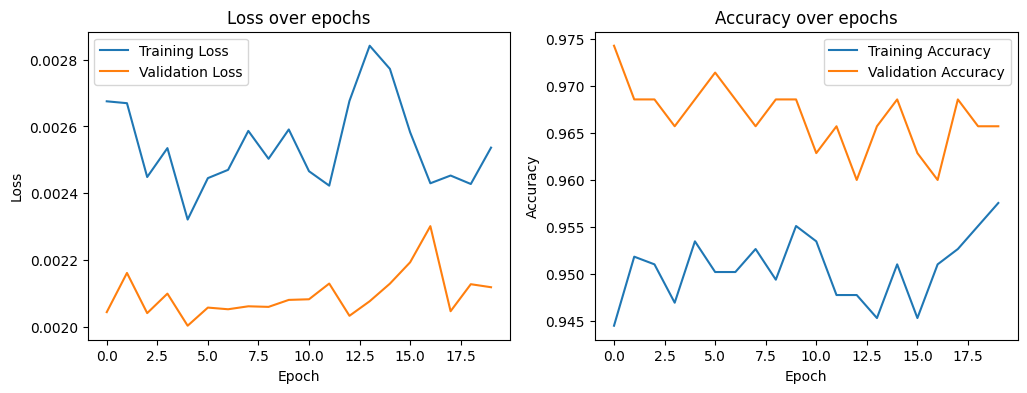

checkpoint_2023-12-18-21-37_lr_0.001_batch_64


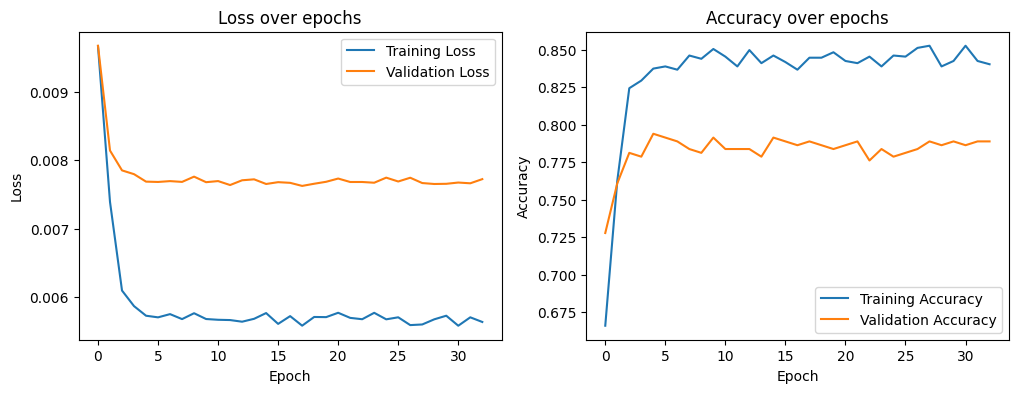

checkpoint_2023-12-18-21-09_lr_0.001_batch_64


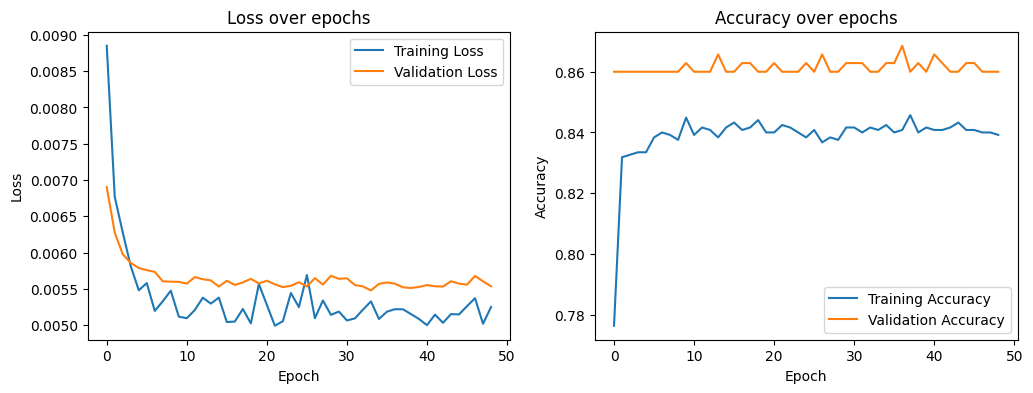

checkpoint_2023-12-18-21-17_lr_0.0001_batch_64


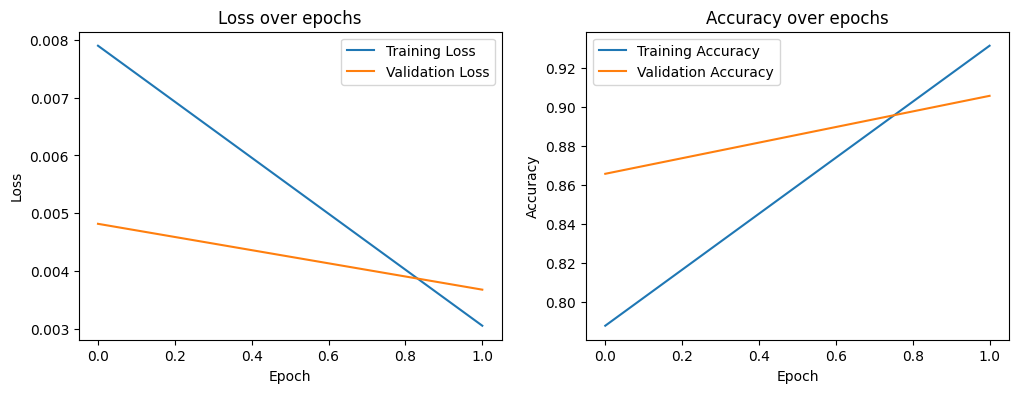

checkpoint_2023-12-17-17-55


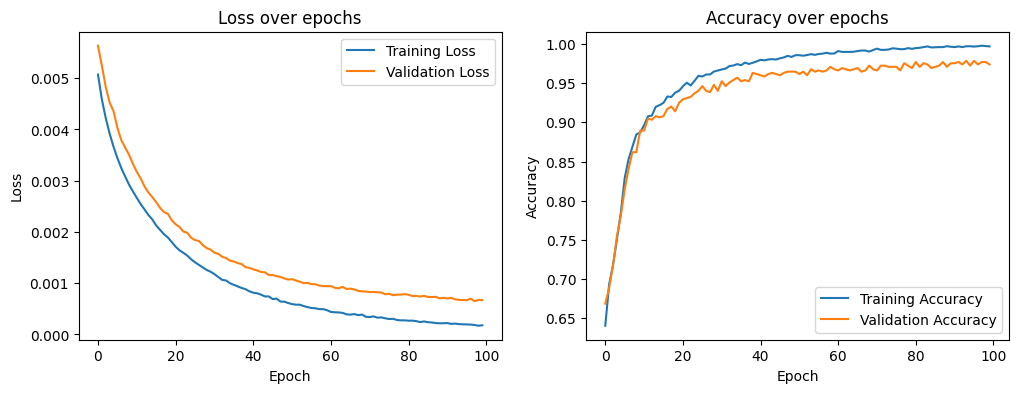

checkpoint_2023-12-18-21-15_lr_0.001_batch_64


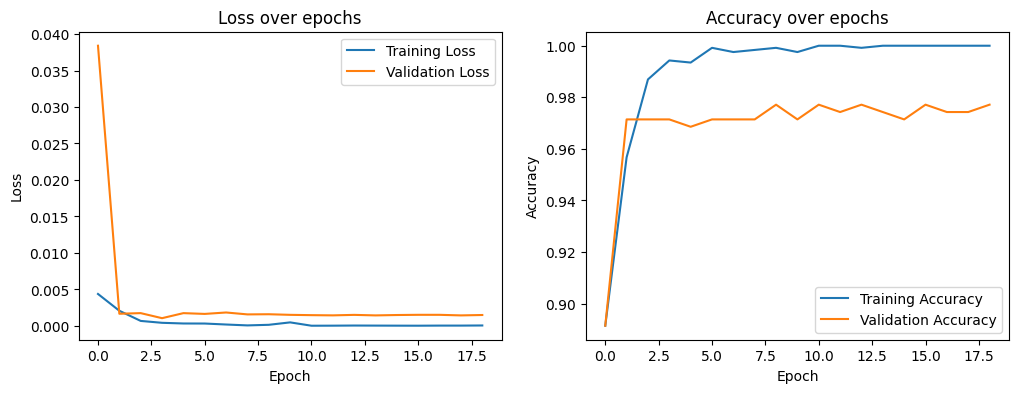

checkpoint_2023-12-18-21-18_lr_0.0001_batch_64


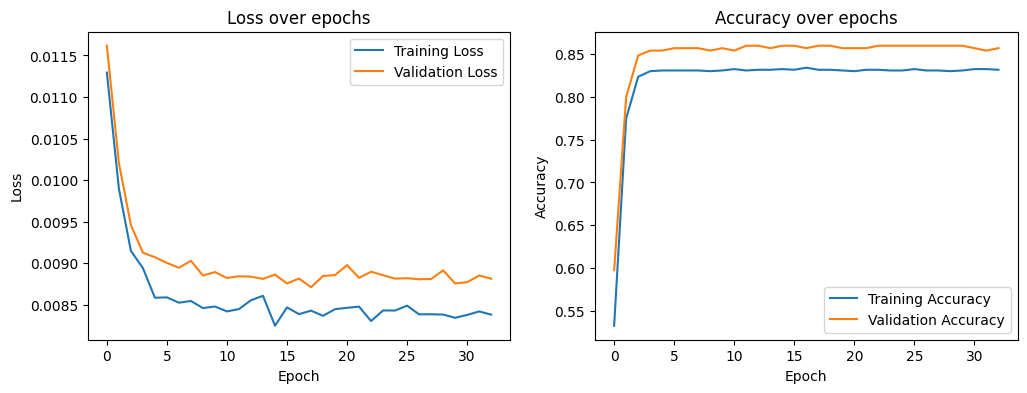

checkpoint_2023-12-18-21-45_lr_0.0001_batch_64


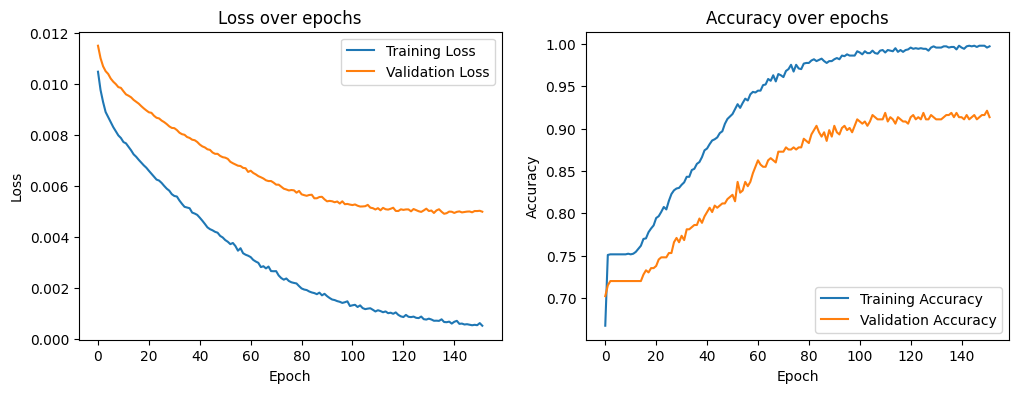

checkpoint_2023-12-17-18-28


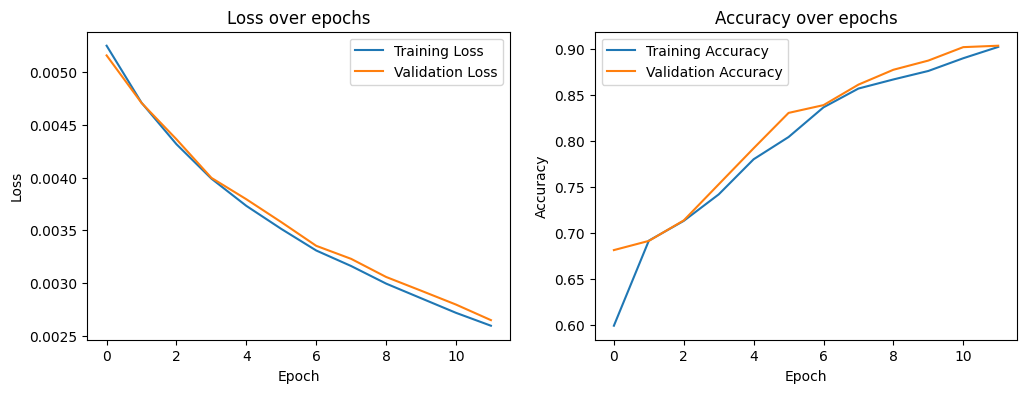

checkpoint_2023-12-18-21-42_lr_1e-05_batch_64


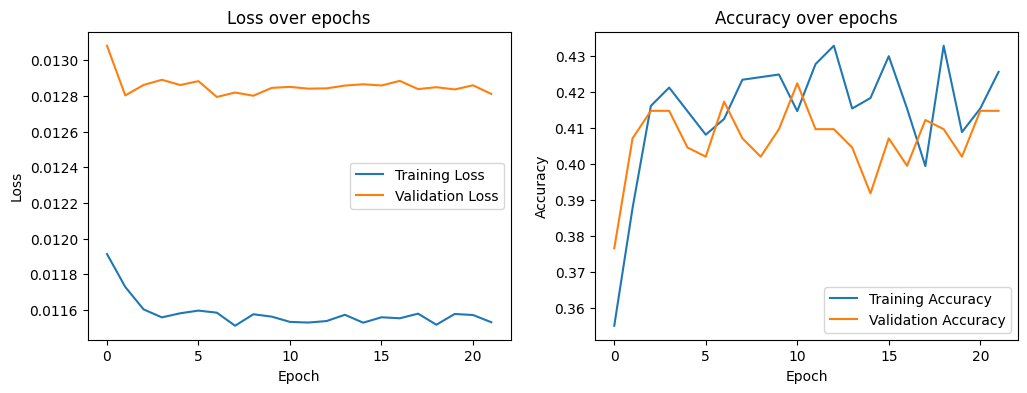

checkpoint_2023-12-18-21-33_lr_0.0001_batch_64


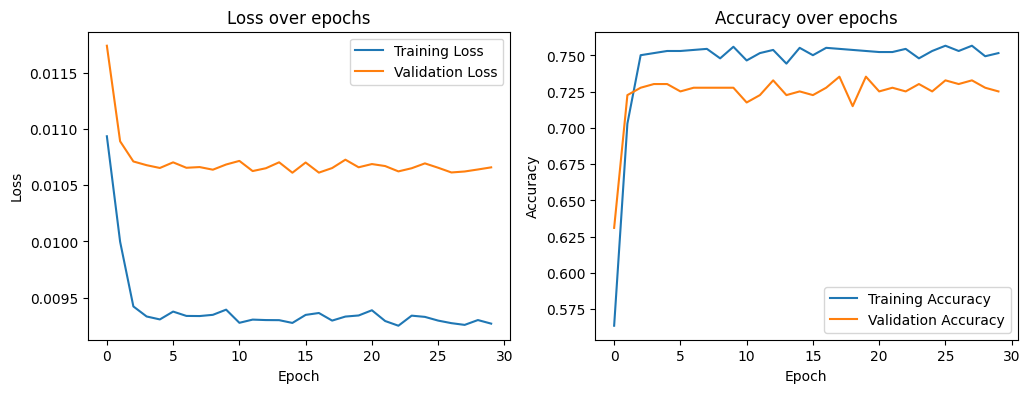

checkpoint_2023-12-17-18-31


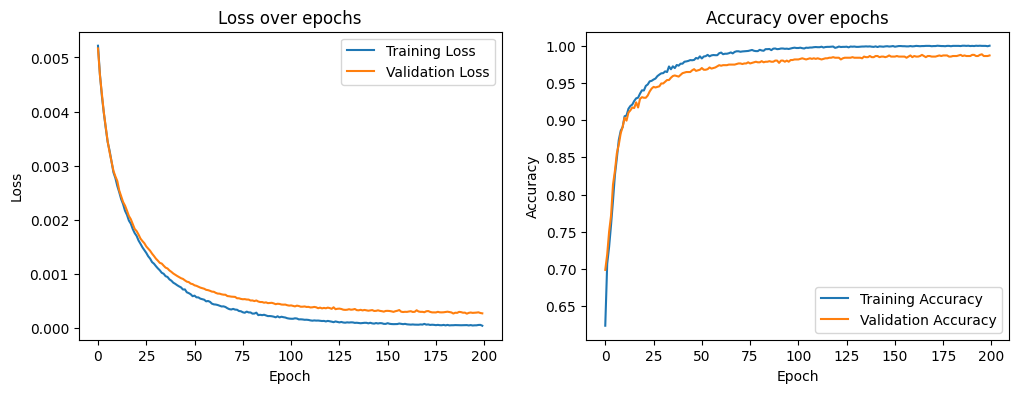

checkpoint_2023-12-18-21-32_lr_0.0001_batch_64


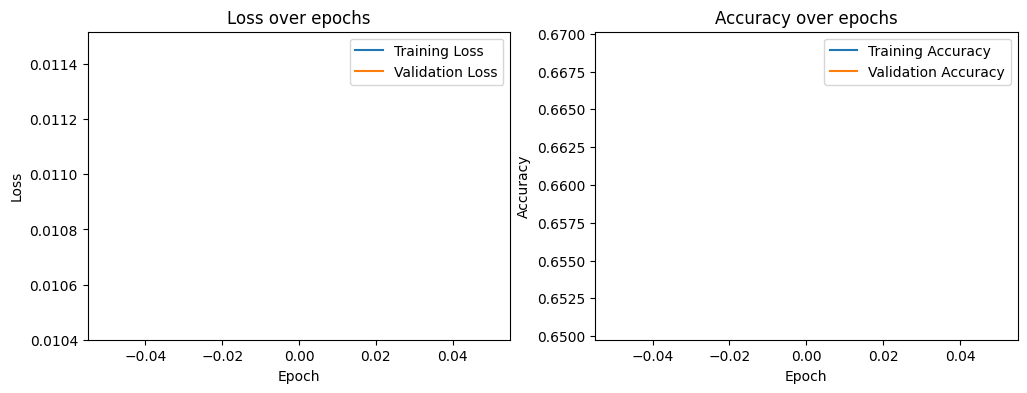

checkpoint_2023-12-17-20-17


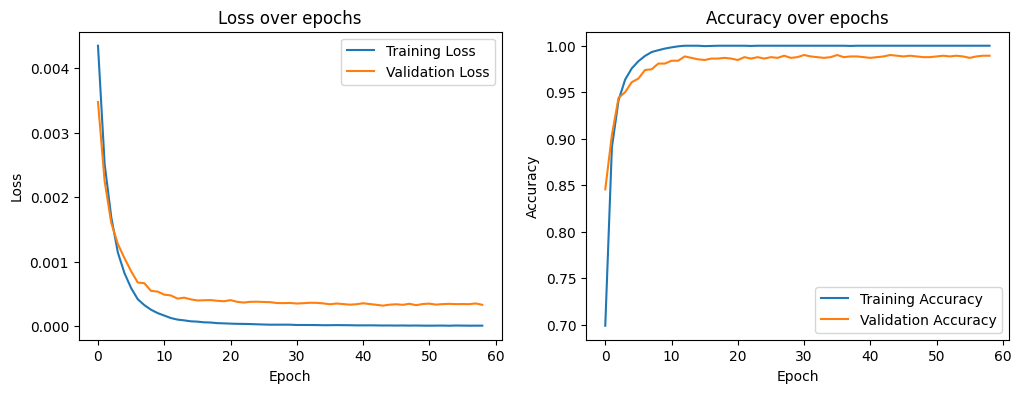

checkpoint_2023-12-19-00-07_lr_0.0005_batch_128


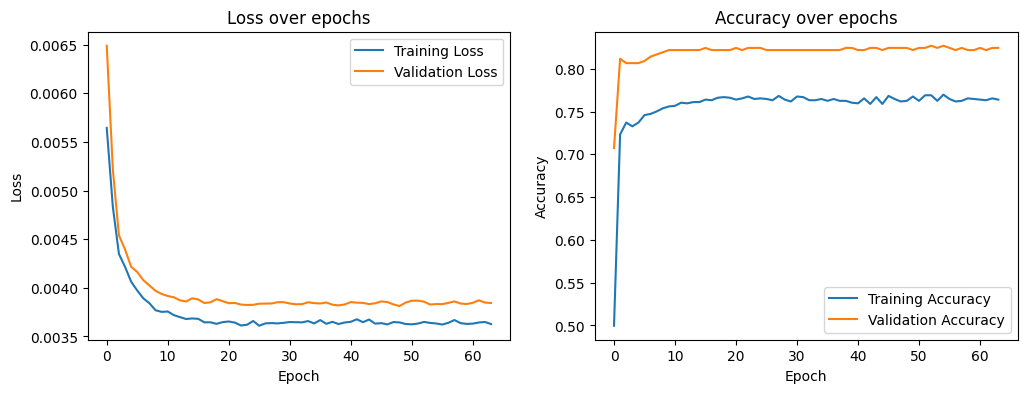

checkpoint_2023-12-17-18-13


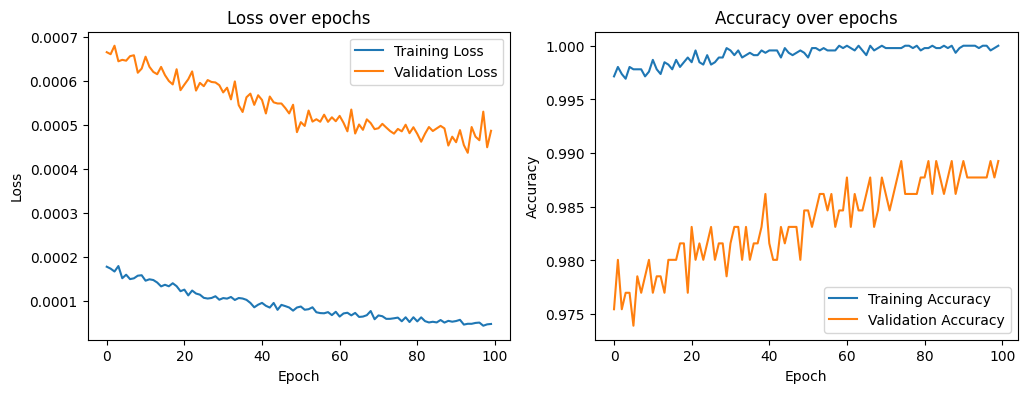

checkpoint_2023-12-18-17-18


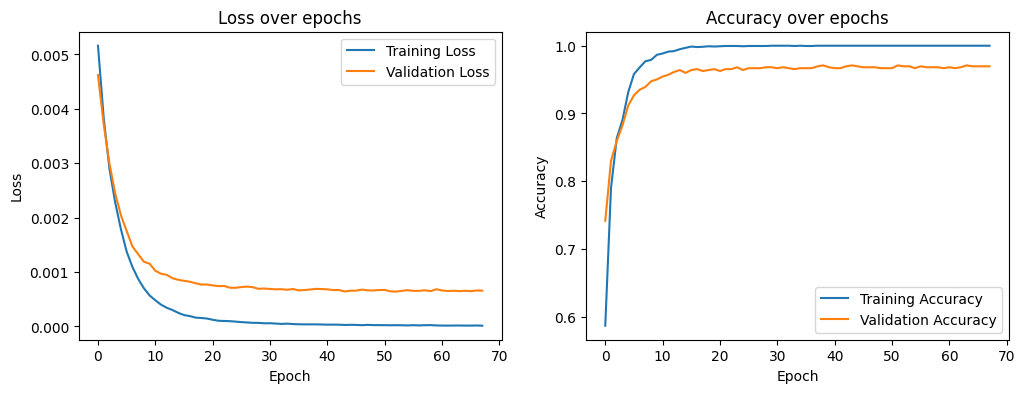

checkpoint_2023-12-18-20-39_lr_0.0001_batch_128


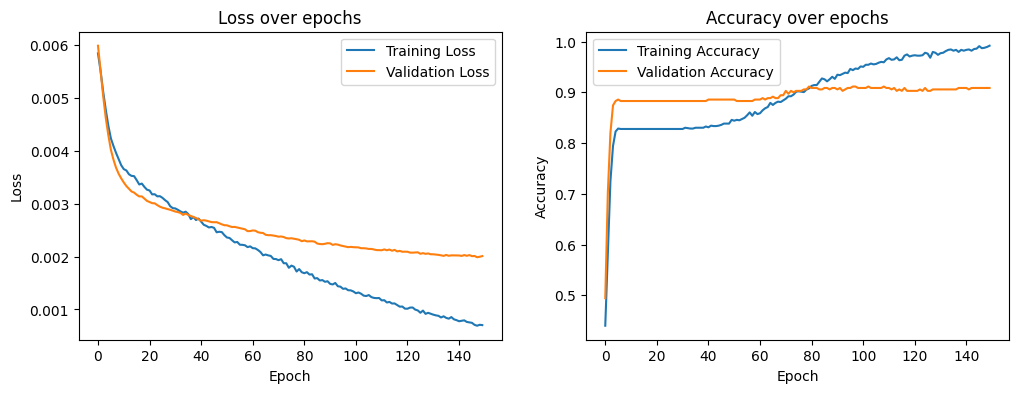

checkpoint_2023-12-19-00-14_lr_0.0003_batch_128


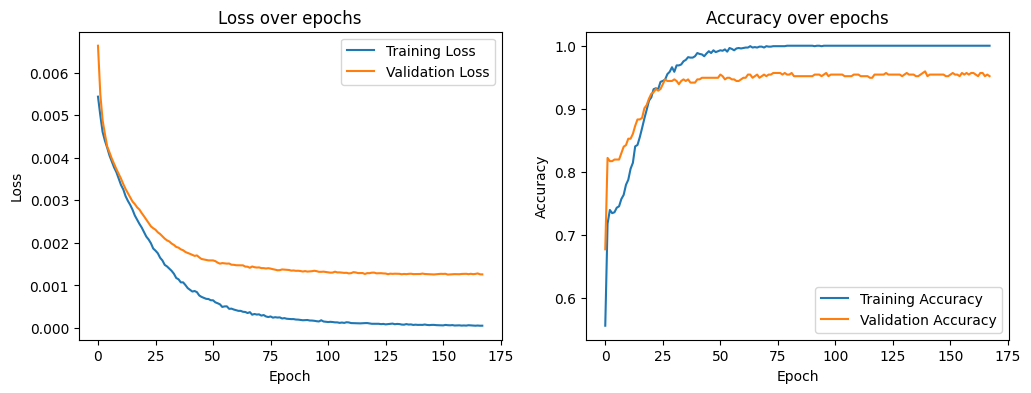

checkpoint_2023-12-18-23-08_lr_0.0001_batch_128


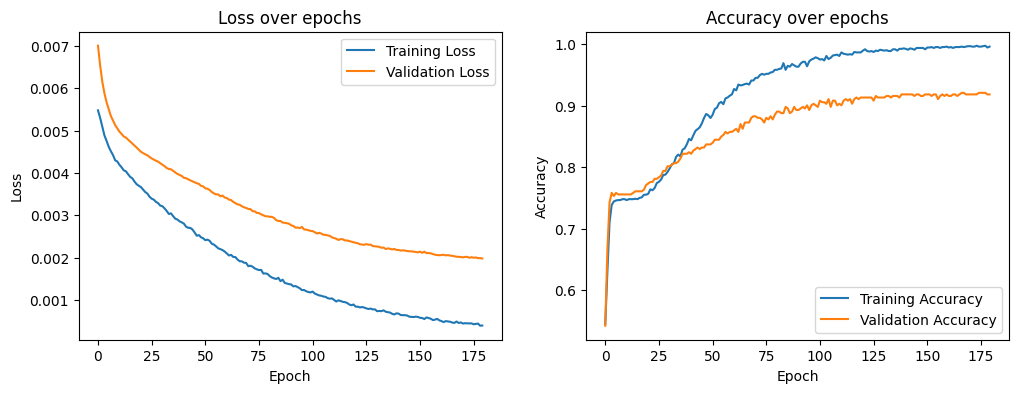

checkpoint_2023-12-18-20-29


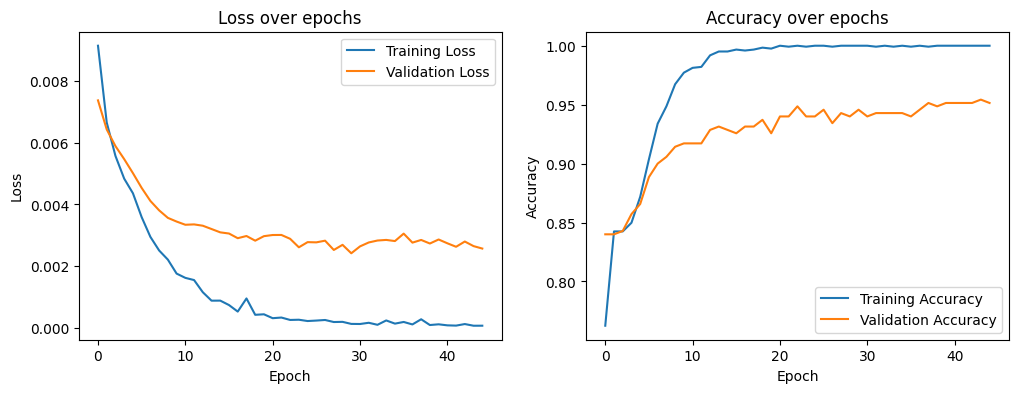

checkpoint_2023-12-18-23-31_lr_0.0001_batch_128


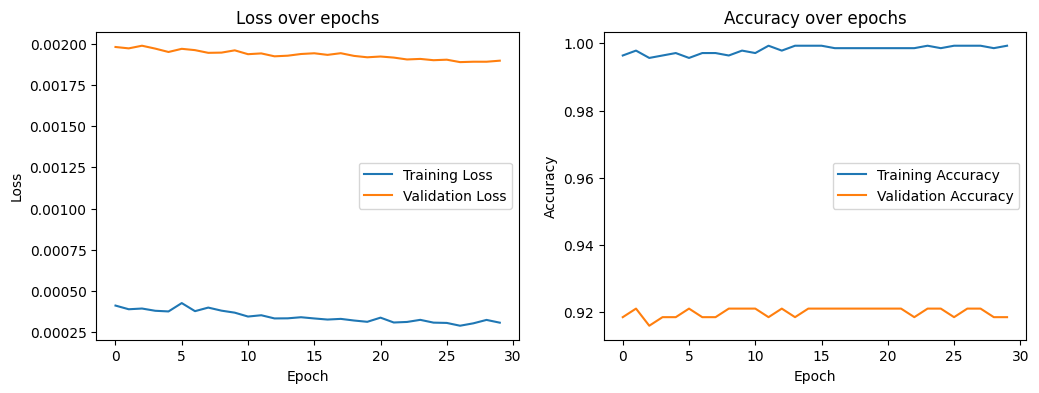

checkpoint_2023-12-18-23-00_lr_0.0001_batch_128


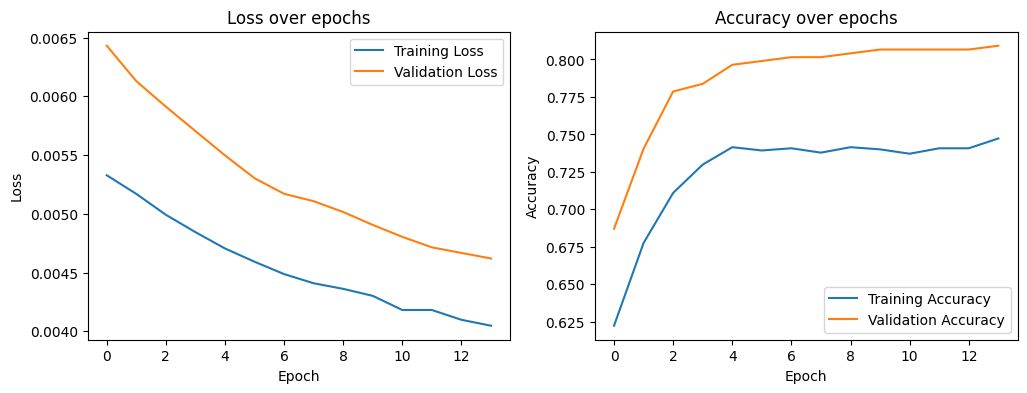

checkpoint_2023-12-19-00-12_lr_5.960464477539063e-11_batch_128


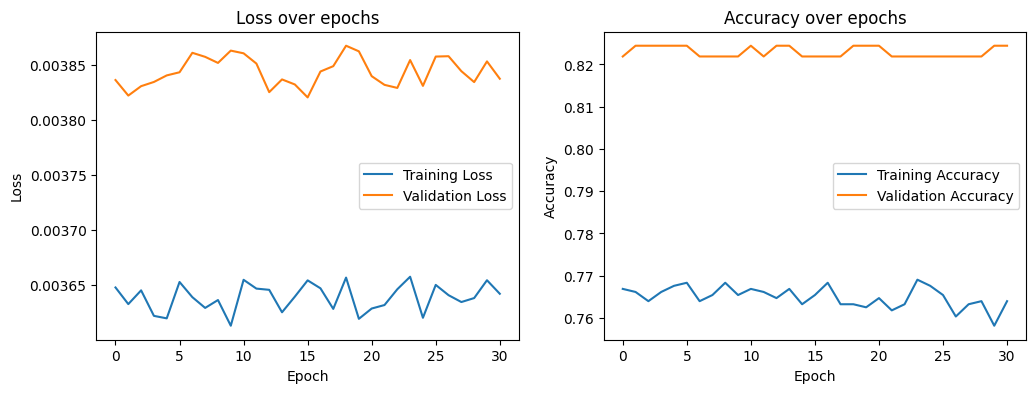

checkpoint_2023-12-19-00-34_lr_0.0003_batch_128


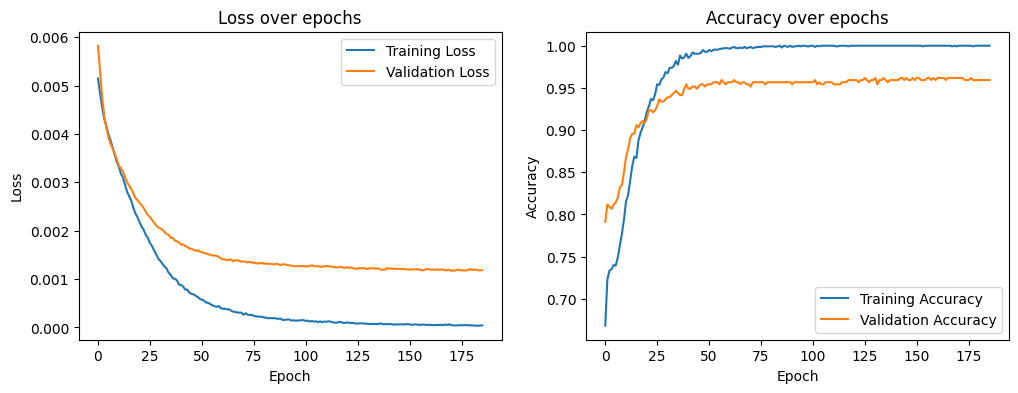

checkpoint_2023-12-17-17-54


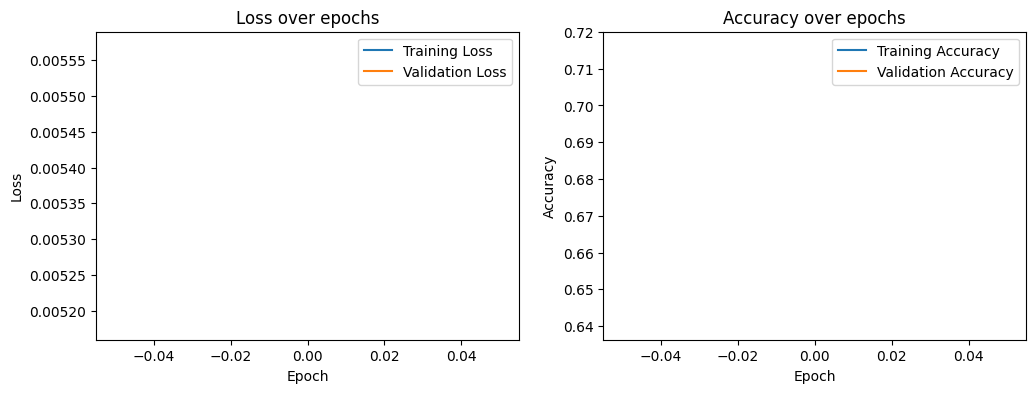

In [11]:
base_dir = "cls_chkpoint_resnet50"
for chks in os.listdir(base_dir):
    
    if not os.path.exists(os.path.join(f"{base_dir}/{chks}/history.json")):
        continue
    else:
        print(chks)
        with open(os.path.join(f"{base_dir}/{chks}/history.json")) as f:
            history = json.load(f)
        plot_training_history(history)